# Indus Valley Script- Text Analysis for Decipherment
# Anomalous Text Analysis

This file is used to identify Anamalous texts using the language models

Dataset was created as a csv file from ICIT web site from raw html files of ICIT code for each for the Text
Data labels were changes and a linearized copy of the original text was added

### Input:
Pickled data file from Language Models and Indus Core and Non Core region data

### Output:
Test results


In [1]:
!pip install numpy
!pip install pandas
!python3 -m pip install matplotlib
!pip3 install scikit-learn
!pip3 install nltk
!pip3 install ipywidgets
!pip3 install -U dill
!pip3 install requests
!pip3 install -U spacy
!pip3 install numpy

zsh:1: command not found: pip
zsh:1: command not found: pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import collections
import random
import traceback
import pickle
import copy
#nltk.download('punkt')

#plt.style.use(style='seaborn')
#plt.style.use("seaborn-v0_8")
%matplotlib inline
#%matplotlib notebook

In [3]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from collections import defaultdict
from nltk.lm.preprocessing import pad_both_ends
from nltk.util import everygrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.lm.models import MLE
from nltk.lm.models import KneserNeyInterpolated
from nltk.lm.models import Lidstone
from collections import Counter

In [4]:
random_seed = 8
seed = 8

In [5]:
"""" Unpickle some of the Indus Core  and Non Core Region dataframes needed """

df_core = pd.read_pickle('pickle/core_df.pkl')
df_core_train_x = pd.read_pickle('pickle/core_train_x.pkl')
df_core_train_y = pd.read_pickle('pickle/core_train_y.pkl')
df_core_train = pd.read_pickle('pickle/core_train_df.pkl')


df_core_rev = pd.read_pickle('pickle/core_rev_df.pkl')
df_core_train_x_rev = pd.read_pickle('pickle/core_train_x_rev.pkl')
df_core_train_y_rev = pd.read_pickle('pickle/core_train_y_rev.pkl')
df_core_train_rev = pd.read_pickle('pickle/core_train_rev_df.pkl')

df_core_test_x = pd.read_pickle('pickle/core_test_x.pkl')
df_core_test_y= pd.read_pickle('pickle/core_test_y.pkl')
df_core_test = pd.read_pickle('pickle/core_test_df.pkl')


print("Core Train size:", len(df_core_train_x))
print("Core Test size:", len(df_core_test_x))

df_core_test_x_rev = pd.read_pickle('pickle/core_test_x_rev.pkl')
df_core_test_y_rev = pd.read_pickle('pickle/core_test_y_rev.pkl')
df_core_test_rev = pd.read_pickle('pickle/core_test_rev_df.pkl')


""" Indus Non Core region texts"""
df_indus_non_core_region = pd.read_pickle('pickle/non_core_df.pkl')
print("Indus Non Core text df: \n", df_indus_non_core_region)

Core Train size: 1770
Core Test size: 443
Indus Non Core text df: 
      icit_id                site             keywords text_class lines  \
4782    3884           Tell Umma                Bull1         PP     1   
4796    3897                  Ur                 Gaur         SC     1   
4797    3898                  Ur                 Gaur         UC     1   
15        16          Altyn Depe                  NaN         UC     1   
4780    3882                Susa                 Gaur         LC     1   
2928    2153            Luristan                 Gaur         SC     1   
2721    1971                Kish             Bull1:II         LP     1   
4758    3863  Qala'at al-Bahrain                 Gaur         SC     1   
4760    3865      Ra's al-Junayz                  NaN         SS     1   
161      160               Hajar  Gaur:Scene, 2 Goats         SS     1   

     direction                               text signs complete  \
4782       R/L              +390-004-002-705-127+

In [6]:
""" Function to Restore the models trained by Indus Core train data"""
def restore_model(this_model_name, this_model_order, direction, data_type):

    try:
        """Unpickle the model"""

        file_name = "pickle/"+ this_model_name + "_" + direction + "_" + data_type + "_"+ str(this_model_order) + ".pkl"
        print("Unpickling Model from ", file_name)
        with open(file_name , 'rb') as f:
            this_model = pickle.load(f)

        print("Unpicked Model Check:",this_model,"Order:", this_model.order, this_model.vocab)
    except Exception as e:
        print("Exception:", e.__class__, "restore_model")
        traceback.print_exc()
        
    return copy.deepcopy(this_model)
  

In [7]:
""" Restore the models trained by Indus Core train data"""

model_name_list = ["MLE", "KneserNeyInterpolated", "Laplace", "Lidstone","StupidBackoff", "WittenBellInterpolated"]
model_core_fwd = [[0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]]
model_core_rev = [[0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]]

#print(model_core_fwd)

for model_name in model_name_list:
    index = model_name_list.index(model_name)
    # TBD: this should be from (2,9) to get all models - changing it to (7,8) so that it completes in Github display
    for model_order in range(7, 8):
        model_core_fwd[index][model_order] = model_name + ":" + str(index) + ":" + str(model_order)
        model_core_fwd[index][model_order] = restore_model(model_name, model_order,"fwd","core_train")
        model_core_rev[index][model_order] = restore_model(model_name, model_order,"rev","core_train")
        #print("---> Setting ", model_name, index, model_order, ":", model_core_fwd[index][model_order] )

verbose_debug = False
if(verbose_debug):
    for model_name in model_name_list:
        index = model_name_list.index(model_name)
        # TBD: this should be from (2,9) to get all model - changing it to (7,8) so that it completes in Github display
        for model_order in range(7, 8):
            print("**", index, model_order, model_core_fwd[index][model_order],  model_core_fwd[index][model_order].order)
            #print("**", index, model_order, model_core_fwd[index][model_order])

Unpickling Model from  pickle/MLE_fwd_core_train_7.pkl
Unpicked Model Check: <nltk.lm.models.MLE object at 0x107832830> Order: 7 <Vocabulary with cutoff=1 unk_label='<UNK>' and 547 items>
Unpickling Model from  pickle/MLE_rev_core_train_7.pkl
Unpicked Model Check: <nltk.lm.models.MLE object at 0x146d38430> Order: 7 <Vocabulary with cutoff=1 unk_label='<UNK>' and 547 items>
Unpickling Model from  pickle/KneserNeyInterpolated_fwd_core_train_7.pkl
Unpicked Model Check: <nltk.lm.models.KneserNeyInterpolated object at 0x15047b4f0> Order: 7 <Vocabulary with cutoff=1 unk_label='<UNK>' and 547 items>
Unpickling Model from  pickle/KneserNeyInterpolated_rev_core_train_7.pkl
Unpicked Model Check: <nltk.lm.models.KneserNeyInterpolated object at 0x1513ca7a0> Order: 7 <Vocabulary with cutoff=1 unk_label='<UNK>' and 547 items>
Unpickling Model from  pickle/Laplace_fwd_core_train_7.pkl
Unpicked Model Check: <nltk.lm.models.Laplace object at 0x152305900> Order: 7 <Vocabulary with cutoff=1 unk_label='<U

In [8]:
"""Unpickle the Lidstone Septagram model for All Indus Core region data"""

file_name = "pickle/Lidstone_fwd_all_core_train_7.pkl"
print("Unpickling Model from ", file_name)
with open(file_name , 'rb') as f:
    model_all_core_sep_fwd_lid = pickle.load(f)
    
file_name = "pickle/Lidstone_rev_all_core_train_7.pkl"
print("Unpickling Model from ", file_name)
with open(file_name , 'rb') as f:
    model_all_core_sep_rev_lid = pickle.load(f)
    
print("Unpicked Model Check:",model_all_core_sep_fwd_lid,"Order:", model_all_core_sep_fwd_lid.order, model_all_core_sep_fwd_lid.vocab)
print("Unpicked Model Check:",model_all_core_sep_rev_lid,"Order:", model_all_core_sep_rev_lid.order, model_all_core_sep_rev_lid.vocab)



Unpickling Model from  pickle/Lidstone_fwd_all_core_train_7.pkl
Unpickling Model from  pickle/Lidstone_rev_all_core_train_7.pkl
Unpicked Model Check: <nltk.lm.models.Lidstone object at 0x1374bf0d0> Order: 7 <Vocabulary with cutoff=1 unk_label='<UNK>' and 599 items>
Unpicked Model Check: <nltk.lm.models.Lidstone object at 0x137b8ae00> Order: 7 <Vocabulary with cutoff=1 unk_label='<UNK>' and 599 items>


In [9]:
def reverse_single_text(text):
    list_reversed_text = []
    # Tokenize to words
    # first split the string into chars
    chars = text.split(' ')

    # then reverse the split string list and join with a space
    reversed_text = ' '.join(reversed(chars))
    return reversed_text

In [10]:
""" Add initial and terminal padding to each text"""
def pad(text):
    return "<s> " + text + " </s>"

In [11]:
def get_perplexity0(model1, k, this_texts, this_tokenized_text,seed=8):
    perplexity_list = []
    try:
        this_data_list = []
        this_data_list, _= padded_everygram_pipeline(k, this_tokenized_text)
        for i, test in enumerate(this_data_list):
            if(this_texts[i]!=" "):
                perp = model1.perplexity(test)
                #print("Test:", test,"Perpleixty:", perp)
                if(perp>100000): perp = 100000
            else: perp = 0
            perplexity_list.append(perp)
            #print("Perplexity( {0}):{1}".format(this_texts[i], model1.perplexity(test)))
    except Exception as e:
                print("Exception:", e.__class__, "get_perplexity")
                traceback.print_exc()
    return this_texts, perplexity_list

# Anamolous texts - Tests

In [12]:
# Function for running a test for anamolous texts
def run_test_anamolous_texts(test_name,data_to_use, model_fwd, model_rev, order, a, a_rev,seed):
    
    verbose_debug= True
    quadgram_models= False


    print("_____________________________")
    print("_____ Running ", test_name, "_________")
    print("_____________________________")

    this_tokenized_text = None
    this_text_list =[]
    this_tokenized_text_list=[]
    text_list = []
    perplexity_list_fwd_text = []
    this_tokenized_text_list = []
    text_len_list=[]
        
    out_dict =  defaultdict()
    net_dict = defaultdict()
    metrics_list = None


    try_reverse = False

    try:

        """ Code to run the Perplexity text and return results"""

        if(use_fwd_model):
            this_text_list = list(a)
            model_in = model_fwd
        else:
            this_text_list = list(a_rev)
            model_in = model_rev

        for text in a:

            """Remove the padding as get_perplexity0 needs unpadded text"""
            text_without_padding = text.replace('<s>', "")
            text_without_padding = text_without_padding.replace('</s>', "")

            this_tokenized_text= word_tokenize(text_without_padding)
            text_len_list.append(len(this_tokenized_text))

            this_tokenized_text_list.append(this_tokenized_text)
            #print(this_tokenized_text_list)


        text_list, perplexity_list_fwd_text = get_perplexity0(model_in, order, this_text_list, this_tokenized_text_list,seed=8)

            
    except Exception as e:
        print("Exception:", e.__class__, "run_test_anamolous_texts")
        traceback.print_exc()
    
    return  text_list, text_len_list, perplexity_list_fwd_text

In [13]:
def prepare_data_anamolous_texts(df_in,max_text_chars,min_text_chars,max_num_of_rows,operation, seed):

    list_changed_texts = []
    list_changed_reversed_text = []
    row_count=0
    ls_made_up_row = []
    random.seed(seed)
    df_made_up = None

    try:
        a = df_in[df_in.l_to_r_text!=''].l_to_r_text
        
        df_in = df_in.reset_index() #indexes should pair with number of rows

        
        for index, row in df_in.iterrows():
            """ Tokenize to words, first split the string into chars """
            text = row['l_to_r_text']
            site = row['site']
            icit_id = row['icit_id']
            
            chars = text.split(' ')
            new_text = chars
            
            if(operation=="shuffle"):
                # Randomly shuffle the list
                random.shuffle(new_text)
            elif(operation=="random"):
                # Randomly generate signs
                for i in range(0, len(new_text)):
                    rand_sign = random.randint(0, 709)
                    new_text[i] = f"{rand_sign:03}"
                
            #print("text, len(chars),max_text_chars,min_text_chars,row_count",text, len(chars),max_text_chars,min_text_chars,row_count)

            if(len(chars)<=max_text_chars and len(chars)>=min_text_chars) :

                changed_text = ' '.join((new_text))

                made_up_row= {'site' : site,
                   'changed_reversed_text'  : pad(reverse_single_text(changed_text)),
                   'changed_text' : pad(changed_text),
                   'icit_id' : icit_id}

                ls_made_up_row.append(made_up_row)


                row_count=row_count+1
                if(row_count>=max_num_of_rows): break


        df_made_up = pd.DataFrame(ls_made_up_row)
    
    except Exception as e:
        print("Exception:", e.__class__, "prepare_data_anamolous_texts")
        traceback.print_exc()
        
    return df_made_up
    

In [14]:
""" test_anamolous_texts_run

Function to Run the test
""" 
def test_anamolous_texts_run(df_this,model_fwd, model_rev, seed):
    verbose_debug = True
    
    text_list = []
    perplexity_list_fwd_text = []
    text_len_list= []
    
    try:
        a = df_this[df_this.changed_text!=''].changed_text
        a_rev = df_this[df_this.changed_reversed_text!=''].changed_reversed_text

        text_list,text_len_list, perplexity_list_fwd_text = run_test_anamolous_texts("test_Anamolous_texts_run","Data",model_fwd, model_rev, model_order, a, a_rev,seed )
    
        
    except Exception as e:
        print("Exception:", e.__class__, "test_Anamolous_texts_run")
        traceback.print_exc()
    return text_list, text_len_list, perplexity_list_fwd_text

## Anamolous Texts Test 1 - With Train data

In [15]:
"""Set the model and Model order to use"""

use_fwd_model = True # Use Forward model
find_best_model= False # Turn this to True when trying to find best model. Used in Test 2
model_order=7

model_name= "Lidstone"
index = model_name_list.index(model_name)
        
model_fwd = model_core_fwd[index][model_order]
model_rev = model_core_rev[index][model_order]

"""This is the best model selected based on tests"""
model_all_fwd =  model_all_core_sep_fwd_lid #model_fwd
model_all_rev =  model_all_core_sep_rev_lid #model_rev

In [16]:
""" Prepare and Run Anamolous_text_Test1"""

verbose_debug= True
min_text_chars = 2
max_text_chars = 40
max_num_of_rows= 4000

text_len_list=[]
df_result_train= df = pd.DataFrame()


df_in = df_core_train

"""Set the number of runs"""
run_num_of_times_train= 1
operation='None'

for x in range(1,run_num_of_times_train+1):
    df_out= None
    this_seed = x
    random.seed(x)
    df_out_train= prepare_data_anamolous_texts(df_in,max_text_chars,min_text_chars,max_num_of_rows, operation, this_seed )
    #print(df_out_train)
    
    text_list_train,text_len_list_train, perplexity_list_fwd_text_train = test_anamolous_texts_run(df_out_train,model_fwd, model_rev, this_seed)
   
    data_type_list_train = ['train'] * len(text_list_train)
    df_result_train['data']=  data_type_list_train
    df_result_train['text_len'] = text_len_list_train
    df_result_train['perplexity'] = perplexity_list_fwd_text_train
    df_result_train['text'] = df_out_train['changed_text'].tolist()
    df_result_train['site'] = df_out_train['site'].tolist() 
    df_result_train['icit_id'] = df_out_train['icit_id'].tolist() 
    #print(df_result_train.to_string())
    df_result_train['rev_text'] = df_out_train['changed_reversed_text'].tolist()

    
    stats_numeric_train = df_result_train['perplexity'].describe()
    print (stats_numeric_train)
    print("median  ", df_result_train['perplexity'].median())
    
    df_result_high_perp_train = df_result_train[df_result_train['perplexity'] > 100]
    print("\n-----High Peplexity Texts-----")
    print(df_result_high_perp_train)
    

_____________________________
_____ Running  test_Anamolous_texts_run _________
_____________________________
count    1661.000000
mean       17.925136
std         7.509214
min         6.395568
25%        12.728973
50%        16.194620
75%        21.390988
max        58.652209
Name: perplexity, dtype: float64
median   16.19462003014132

-----High Peplexity Texts-----
Empty DataFrame
Columns: [data, text_len, perplexity, text, site, icit_id, rev_text]
Index: []


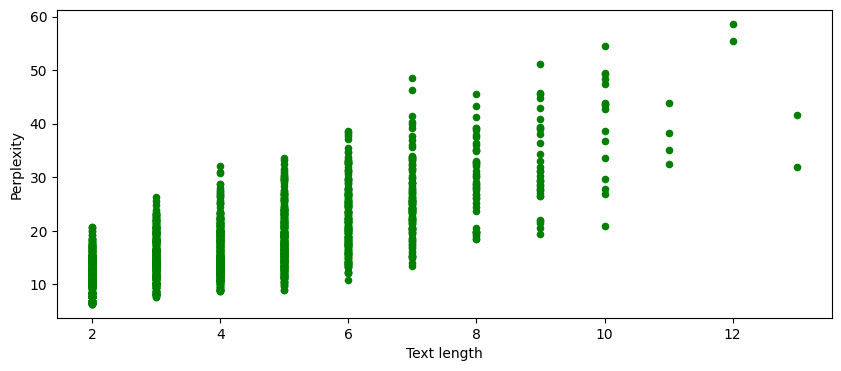

In [17]:
""" Scatter plot the Perplexity"""

plt.figure(1,figsize=(10,4))
plt.scatter(df_result_train['text_len'], df_result_train['perplexity'],  s=20, c='green')
plt.xlabel('Text length')
plt.ylabel('Perplexity')

plt.show()

## Anamolous Texts Test 2 - With Test data

In [18]:
""" Prepare and Run Anamolous_text_Test2"""

verbose_debug= True

min_text_chars = 2
max_text_chars = 40
max_num_of_rows= 400
text_len_list=[]
df_result_test= df = pd.DataFrame()


df_in = df_core_test

"""Set the number of runs"""
run_num_of_times_test= 1
operation='None'

for x in range(1,run_num_of_times_test+1):
    
    df_out_test= None
    this_seed = x
    random.seed(x)
    df_out_test= prepare_data_anamolous_texts(df_in,max_text_chars,min_text_chars,max_num_of_rows,operation, this_seed )
    print(df_out_test)

    """ For Test 2, we run all model and all order to capture which model has smallest Median and Mean perplexity
    That model is then trained on All Core data and tested again Indus Non core region texts later"""
    """ For every model and order get the data for Test set"""

    if(find_best_model):
        for model_name in model_name_list:
            index = model_name_list.index(model_name)
            for model_order in range(2, 9):
                model_test2_fwd = model_core_fwd[index][model_order]
                model_test2_rev = model_core_rev[index][model_order]
                print("---", model_name, model_order , "---")

                text_list_test,text_len_list_test, perplexity_list_fwd_text_test = test_anamolous_texts_run(df_out_test,model_test2_fwd, model_test2_rev, this_seed)
                data_type_list_test = ['test'] * len(text_list_test)
                df_result_test['data']=  data_type_list_test
                df_result_test['text_len'] = text_len_list_test
                df_result_test['perplexity'] = perplexity_list_fwd_text_test
                df_result_test['text'] = df_out_test['changed_text'].tolist()
                df_result_test['site'] = df_out_test['site'].tolist() 
                df_result_test['icit_id'] = df_out_test['icit_id'].tolist() 

                #print(df_result_test.to_string())
                df_result_test['rev_text'] = df_out_test['changed_reversed_text'].tolist() 


                stats_numeric_test = df_result_test['perplexity'].describe()
                print (stats_numeric_test)
                print("median  ", df_result_test['perplexity'].median())

                df_result_high_perp_test = df_result_test[df_result_test['perplexity'] > 100]
                #print("\n-----High Peplexity Texts-----")
                #print(df_result_high_perp_test.to_string())
    else:
        
        """ If not running test to find best model"""
        text_list_test,text_len_list_test, perplexity_list_fwd_text_test = test_anamolous_texts_run(df_out_test,model_fwd, model_rev, this_seed)

        data_type_list_test = ['test'] * len(text_list_test)
        df_result_test['data']=  data_type_list_test
        df_result_test['text_len'] = text_len_list_test
        df_result_test['perplexity'] = perplexity_list_fwd_text_test
        df_result_test['text'] = df_out_test['changed_text'].tolist()
        df_result_test['site'] = df_out_test['site'].tolist() 
        df_result_test['icit_id'] = df_out_test['icit_id'].tolist() 

        #print(df_result_test.to_string())
        df_result_test['rev_text'] = df_out_test['changed_reversed_text'].tolist() 


        stats_numeric_test = df_result_test['perplexity'].describe()
        print (stats_numeric_test)
        print("median  ", df_result_test['perplexity'].median())
        print("90 the Percentile ", df_result_test['perplexity'].quantile(0.9))

        df_result_high_perp_test = df_result_test[df_result_test['perplexity'] > 100]
        #print("\n-----High Peplexity Texts-----")
        #print(df_result_high_perp_test.to_string())
    

             site             changed_reversed_text  \
0    Mohenjo-daro      <s> 740 900 790 233 798 </s>   
1    Mohenjo-daro  <s> 520 235 803 001 368 861 </s>   
2    Mohenjo-daro          <s> 820 880 065 244 </s>   
3    Mohenjo-daro                  <s> 390 005 </s>   
4    Mohenjo-daro              <s> 740 803 235 </s>   
..            ...                               ...   
395  Mohenjo-daro              <s> 400 368 055 </s>   
396       Harappa              <s> 740 255 032 </s>   
397  Mohenjo-daro  <s> 740 032 840 033 705 798 </s>   
398       Harappa      <s> 740 269 511 060 690 </s>   
399  Mohenjo-daro          <s> 156 142 368 817 </s>   

                         changed_text icit_id  
0        <s> 798 233 790 900 740 </s>    2648  
1    <s> 861 368 001 803 235 520 </s>    3219  
2            <s> 244 065 880 820 </s>    2535  
3                    <s> 005 390 </s>    2472  
4                <s> 235 803 740 </s>    2476  
..                                ...     ...  
395

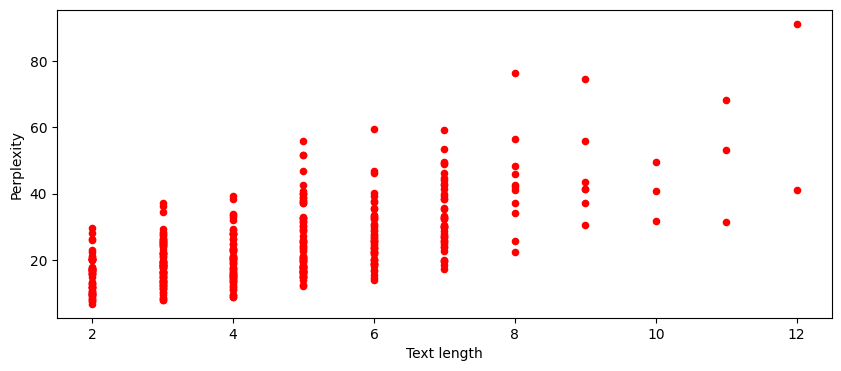

In [19]:
""" Scatter plot the Perplexity"""

plt.figure(2,figsize=(10,4))
plt.scatter(df_result_test['text_len'], df_result_test['perplexity'],  s=20, c='red')
plt.xlabel('Text length')
plt.ylabel('Perplexity')

plt.show()

## Anamolous Texts Test 3.1 - With Randomly generated Texts - Random Shuffle

In [20]:
""" Prepare and Run Anamolous_text_Test3.1"""

verbose_debug= True

min_text_chars = 4
max_text_chars = 40
max_num_of_rows= 400
text_len_list=[]
df_result_random1= df = pd.DataFrame()

df_in = df_core_test

"""Set the number of runs"""
run_num_of_times_random1= 1
operation = "shuffle"


for x in range(1,run_num_of_times_random1+1):
    df_out_random1= None
    this_seed = x
    random.seed(x)
    df_out_random1= prepare_data_anamolous_texts(df_in,max_text_chars,min_text_chars,max_num_of_rows, operation, this_seed )
    print(df_out_random1)
    
    text_list_random1,text_len_list_random1, perplexity_list_fwd_text_random1 = test_anamolous_texts_run(df_out_random1,model_fwd, model_rev, this_seed)
  
   
    data_type_list_random1 = ['random1'] * len(text_list_random1)
    df_result_random1['data']=  data_type_list_random1
    df_result_random1['text_len'] = text_len_list_random1
    df_result_random1['perplexity'] = perplexity_list_fwd_text_random1
    df_result_random1['text'] = df_out_random1['changed_text'].tolist()
    #df_result_random1['site'] = df_out_random1['site'].tolist() 
    #print(df_result_random1.to_string())
    df_result_random1['rev_text'] = df_out_random1['changed_reversed_text'].tolist()
    
    stats_numeric_random1 = df_result_random1['perplexity'].describe()
    print ( stats_numeric_random1)
    print("median  ", df_result_random1['perplexity'].median())
    print("90 the Percentile ", df_result_random1['perplexity'].quantile(0.9))

              site                         changed_reversed_text  \
0     Mohenjo-daro                  <s> 233 798 740 900 790 </s>   
1     Mohenjo-daro              <s> 803 520 235 001 368 861 </s>   
2     Mohenjo-daro                      <s> 065 244 820 880 </s>   
3     Mohenjo-daro              <s> 844 861 240 002 390 806 </s>   
4          Harappa                  <s> 767 416 740 400 220 </s>   
..             ...                                           ...   
261        Harappa                      <s> 400 032 156 140 </s>   
262  Chanhujo-daro                  <s> 803 002 817 520 235 </s>   
263        Harappa                      <s> 352 520 400 400 </s>   
264   Mohenjo-daro              <s> 421 003 790 176 740 100 </s>   
265   Mohenjo-daro  <s> 033 002 220 861 415 033 798 740 760 </s>   

                                     changed_text icit_id  
0                    <s> 790 900 740 798 233 </s>    2648  
1                <s> 861 368 001 235 520 803 </s>    3219  
2  

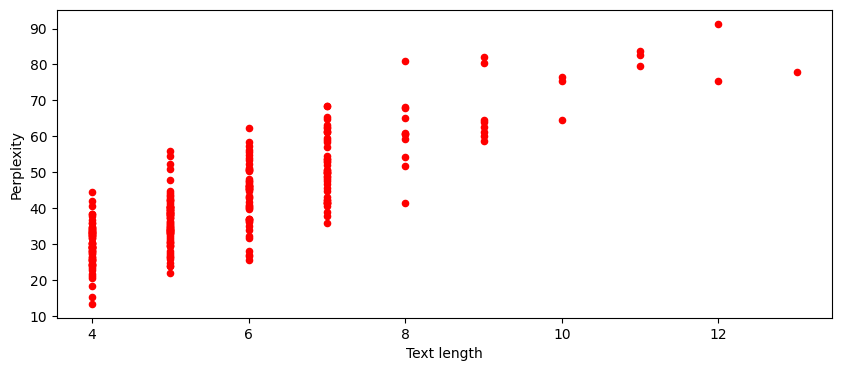

In [21]:
""" Scatter plot the Perplexity"""

plt.figure(3,figsize=(10,4))
plt.scatter(df_result_random1['text_len'], df_result_random1['perplexity'],  s=20, c='red')
plt.xlabel('Text length')
plt.ylabel('Perplexity')

plt.show()

## Anamolous Texts Test 3.2 - With Randomly generated Texts - Full Random

In [22]:
""" Prepare and Run Anamolous_text_Test3.2"""

verbose_debug= True

min_text_chars = 4
max_text_chars = 40
max_num_of_rows= 400
text_len_list=[]
df_result_random2= df = pd.DataFrame()

df_in = df_core_test

"""Set the number of runs"""
run_num_of_times_random2= 1
operation = "random"


for x in range(1,run_num_of_times_random2+1):
    df_out_random2= None
    this_seed = x
    random.seed(x)
    df_out_random2= prepare_data_anamolous_texts(df_in,max_text_chars,min_text_chars,max_num_of_rows, operation, this_seed )
    print(df_out_random2)
    
    text_list_random2,text_len_list_random2, perplexity_list_fwd_text_random2 = test_anamolous_texts_run(df_out_random2,model_fwd, model_rev, this_seed)
  
   
    data_type_list_random2 = ['random2'] * len(text_list_random2)
    df_result_random2['data']=  data_type_list_random2
    df_result_random2['text_len'] = text_len_list_random2
    df_result_random2['perplexity'] = perplexity_list_fwd_text_random2
    df_result_random2['text'] = df_out_random2['changed_text'].tolist()
    #df_result_random2['site'] = df_out_random2['site'].tolist() 
    #print(df_result_random2.to_string())
    df_result_random2['rev_text'] = df_out_random2['changed_reversed_text'].tolist()
    
    stats_numeric_random2 = df_result_random2['perplexity'].describe()
    print ( stats_numeric_random2)
    print("median  ", df_result_random2['perplexity'].median())
    print("90 the Percentile ", df_result_random2['perplexity'].quantile(0.9))

              site                         changed_reversed_text  \
0     Mohenjo-daro                  <s> 120 261 064 582 137 </s>   
1     Mohenjo-daro              <s> 214 388 667 483 460 507 </s>   
2     Mohenjo-daro                      <s> 399 029 499 096 </s>   
3     Mohenjo-daro              <s> 026 022 031 325 104 605 </s>   
4          Harappa                  <s> 029 432 221 702 390 </s>   
..             ...                                           ...   
261        Harappa                      <s> 038 274 236 628 </s>   
262  Chanhujo-daro                  <s> 567 686 687 171 653 </s>   
263        Harappa                      <s> 408 431 677 280 </s>   
264   Mohenjo-daro              <s> 016 572 191 132 685 100 </s>   
265   Mohenjo-daro  <s> 514 609 177 193 452 432 043 694 078 </s>   

                                     changed_text icit_id  
0                    <s> 137 582 064 261 120 </s>    2648  
1                <s> 507 460 483 667 388 214 </s>    3219  
2  

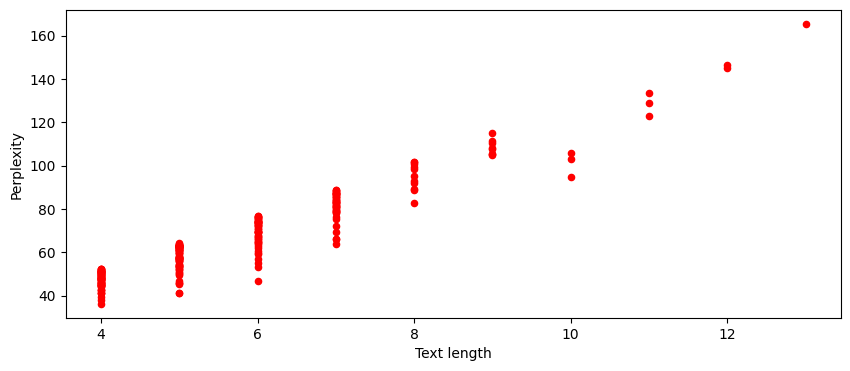

In [23]:
""" Scatter plot the Perplexity"""

plt.figure(9,figsize=(10,4))
plt.scatter(df_result_random2['text_len'], df_result_random2['perplexity'],  s=20, c='red')
plt.xlabel('Text length')
plt.ylabel('Perplexity')

plt.show()

## Anomalous Texts Test 4 - Indus Non Core Region (West Asia) texts

In [24]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from IPython.display import display, HTML


def get_img_urls(sign_number_list):

    img_urls = "<figure class=\"item\" style=\"display:flex\">"

    for sign_number in sign_number_list:
        if(sign_number != "<s>" and sign_number != "</s>" ):
            img_urls = img_urls + " " + "<img src=\"../ICIT/ICIT Sign List/S" + str(sign_number) + ".jpg\" alt=\"img\" width=\"15\" height=\"10\" class=\"w3-image\">"
            img_urls = img_urls + " " + "<figcaption class=\"caption\">" + str(sign_number) + "</figcaption>"
    img_urls = img_urls + " " + "</figure>"
    return img_urls

def display_table(df_inp,caption):
    pd.set_option('display.colheader_justify', 'left')
    
    orig_text_sign = 'text_img'
    
    df_inp_top_x = df_inp.copy()
    df_inp_top_x.style.set_properties(**{'text-align': 'left'})
    df_inp_top_x[orig_text_sign] = None

    
    for i in range(0, len(df_inp_top_x)):
        df_inp_top_x.loc[i:,orig_text_sign] = get_img_urls(df_inp_top_x.loc[i]['text'].split())


    df_inp_top_x.style.set_caption(caption)
    df_inp_top_x.style.set_properties(subset=[orig_text_sign], **{'width-min': '200px'})


    display(HTML(df_inp_top_x[["icit_id","site", "text_len", "perplexity", orig_text_sign]].to_html(escape=False, index=False)))
 
    

In [25]:
""" Prepare and Run Anamolous_text_Test4"""

verbose_debug= True

min_text_chars = 2
max_text_chars = 40
max_num_of_rows= 10
text_len_list=[]
df_result_non_core= df = pd.DataFrame()

df_in = df_indus_non_core_region

"""Set the number of runs"""
run_num_of_times_non_core= 1
operation = "None"


for x in range(1,run_num_of_times_non_core+1):
    df_out_non_core= None
    this_seed = x
    random.seed(x)
    df_out_non_core= prepare_data_anamolous_texts(df_in,max_text_chars,min_text_chars,max_num_of_rows, operation, this_seed )
    print(df_out_non_core)
    
    """ Notice that the model used here is the best model and is trained on All core data (core train + core test)"""
    text_list_non_core,text_len_list_non_core, perplexity_list_fwd_text_non_core = test_anamolous_texts_run(df_out_non_core,model_all_fwd, model_all_rev, this_seed)
  
   
    data_type_list_non_core = ['non_core'] * len(text_list_non_core)
    df_result_non_core['data']=  data_type_list_non_core
    df_result_non_core['text_len'] = text_len_list_non_core
    df_result_non_core['perplexity'] = perplexity_list_fwd_text_non_core
    df_result_non_core['text'] = df_out_non_core['changed_text'].tolist()
    df_result_non_core['site'] = df_out_non_core['site'].tolist() 
    df_result_non_core['icit_id'] =df_out_non_core['icit_id'].tolist() 
    #print(df_result_non_core.to_html())
    from IPython.display import display

    #display(df_result_non_core)
    display_table(df_result_non_core,"West Asian Indus Texts")
    
    df_result_non_core['rev_text'] = df_out_non_core['changed_reversed_text'].tolist()
    
    stats_numeric_non_core = df_result_non_core['perplexity'].describe()
    print (stats_numeric_non_core)

    df_result_high_perp_non_core = df_result_non_core[(df_result_non_core['perplexity'] > 40) & (df_result_non_core['text_len'] > 2) ]
    print("\n-----High Peplexity Texts-----")
    print(df_result_high_perp_non_core)
    

                 site                     changed_reversed_text  \
0           Tell Umma              <s> 390 004 002 705 127 </s>   
1                  Ur              <s> 093 340 924 220 528 </s>   
2                  Ur          <s> 002 004 328 001 803 415 </s>   
3          Altyn Depe                          <s> 415 390 </s>   
4                Susa  <s> 416 150 002 055 031 319 001 924 </s>   
5            Luristan                  <s> 831 413 840 091 </s>   
6                Kish  <s> 740 390 590 220 003 060 840 416 </s>   
7  Qala'at al-Bahrain              <s> 190 060 055 090 160 </s>   
8      Ra's al-Junayz                          <s> 405 004 </s>   
9               Hajar                          <s> 617 117 </s>   

                               changed_text icit_id  
0              <s> 127 705 002 004 390 </s>    3884  
1              <s> 528 220 924 340 093 </s>    3897  
2          <s> 415 803 001 328 004 002 </s>    3898  
3                          <s> 390 415 </s>   

icit_id,site,text_len,perplexity,text_img
3884,Tell Umma,5,29.062552,127 705 002 004 390
3897,Ur,5,55.855452,528 220 924 340 093
3898,Ur,6,45.205587,415 803 001 328 004 002
16,Altyn Depe,2,19.076793,390 415
3882,Susa,8,76.138530,924 001 319 031 055 002 150 416
2153,Luristan,4,42.808912,091 840 413 831
1971,Kish,8,29.440489,416 840 060 003 220 590 390 740
3863,Qala'at al-Bahrain,5,54.999468,160 090 055 060 190
3865,Ra's al-Junayz,2,14.317761,004 405
160,Hajar,2,20.295460,117 617


count    10.000000
mean     38.720100
std      19.770172
min      14.317761
25%      22.487233
50%      36.124700
75%      52.550998
max      76.138530
Name: perplexity, dtype: float64

-----High Peplexity Texts-----
  data       text_len  perplexity text                                       \
1  non_core  5         55.855452               <s> 528 220 924 340 093 </s>   
2  non_core  6         45.205587           <s> 415 803 001 328 004 002 </s>   
4  non_core  8         76.138530   <s> 924 001 319 031 055 002 150 416 </s>   
5  non_core  4         42.808912                   <s> 091 840 413 831 </s>   
7  non_core  5         54.999468               <s> 160 090 055 060 190 </s>   

  site                icit_id rev_text                                   
1                  Ur  3897                <s> 093 340 924 220 528 </s>  
2                  Ur  3898            <s> 002 004 328 001 803 415 </s>  
4                Susa  3882    <s> 416 150 002 055 031 319 001 924 </s>  
5           

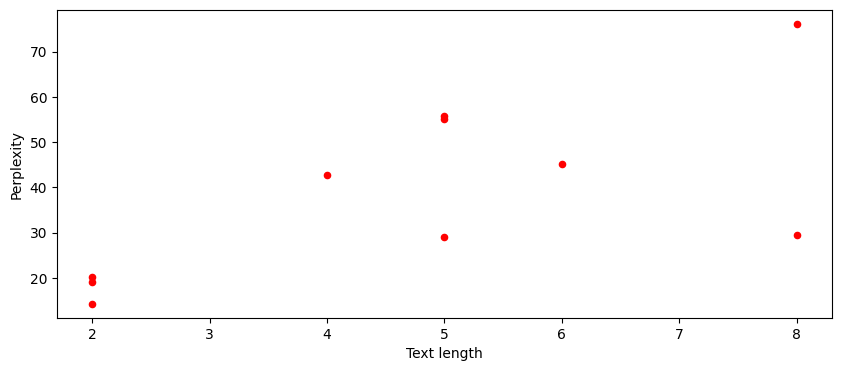

In [26]:
""" Scatter plot the Perplexity"""

plt.figure(5,figsize=(10,4))
plt.scatter(df_result_non_core['text_len'], df_result_non_core['perplexity'],  s=20, c='red')
plt.xlabel('Text length')
plt.ylabel('Perplexity')

plt.show()

## Anomalous Texts Test 5 - South India texts

In [27]:
""" South Indian texts"""
# At this point this has only one South Indian texts
df_indus_si_region= df = pd.DataFrame()
df_indus_si_region['l_to_r_text'] =["<s> 176 740 776 921 </s>"] # ["<s> 921 776 740 176"]
df_indus_si_region['site'] = ["Sembiyan Kandiyur"]
df_indus_si_region['icit_id'] = ["Undocumented"]

In [28]:
""" Prepare and Run Anamolous_text_Test5"""

verbose_debug= True

min_text_chars = 2
max_text_chars = 40
max_num_of_rows= 10
text_len_list=[]
df_result_si= df = pd.DataFrame()

df_in = df_indus_si_region

"""Set the number of runs"""
run_num_of_times_si= 1
operation = "None"


for x in range(1,run_num_of_times_si+1):
    df_out_si= None
    this_seed = x
    random.seed(x)
    df_out_si= prepare_data_anamolous_texts(df_in,max_text_chars,min_text_chars,max_num_of_rows, operation, this_seed )
    print(df_out_si)
    
    """ Notice that the model used here is the best model and is trained on All core data (core train + core test)"""
    text_list_si,text_len_list_si, perplexity_list_fwd_text_si = test_anamolous_texts_run(df_out_si,model_all_fwd, model_all_rev, this_seed)
  
   
    data_type_list_si = ['si'] * len(text_list_si)
    df_result_si['data']=  data_type_list_si
    df_result_si['text_len'] = text_len_list_si
    df_result_si['perplexity'] = perplexity_list_fwd_text_si
    df_result_si['text'] = df_out_si['changed_text'].tolist()
    df_result_si['site'] = df_out_si['site'].tolist() 
    df_result_si['icit_id'] =df_out_si['icit_id'].tolist() 
    #print(df_result_si.to_html())
    from IPython.display import display

    #display(df_result_si)
    display_table(df_result_si,"South India Indus Texts")
    
    df_result_si['rev_text'] = df_out_si['changed_reversed_text'].tolist()
    
    stats_numeric_si = df_result_si['perplexity'].describe()
    print (stats_numeric_si)

    #For Lidstone n=7
    df_result_high_perp_si = df_result_si[(df_result_si['perplexity'] > 40) & (df_result_si['text_len'] > 2) ]
    print("\n-----High Peplexity Texts-----")
    print(df_result_high_perp_si)
    

  site               changed_reversed_text               \
0  Sembiyan Kandiyur  <s> </s> 921 776 740 176 <s> </s>   

  changed_text                       icit_id        
0  <s> <s> 176 740 776 921 </s> </s>  Undocumented  
_____________________________
_____ Running  test_Anamolous_texts_run _________
_____________________________


icit_id,site,text_len,perplexity,text_img
Undocumented,Sembiyan Kandiyur,4,28.549214,176 740 776 921


count     1.000000
mean     28.549214
std            NaN
min      28.549214
25%      28.549214
50%      28.549214
75%      28.549214
max      28.549214
Name: perplexity, dtype: float64

-----High Peplexity Texts-----
Empty DataFrame
Columns: [data, text_len, perplexity, text, site, icit_id, rev_text]
Index: []


## All anomalous texts

In [29]:
"""Concatanate the High Perplexity text rows from train, test and actual non_core"""

frames = [df_result_high_perp_train, df_result_high_perp_test, df_result_high_perp_non_core]

df_result_high_perp_all= pd.concat(frames)
print(df_result_high_perp_all)

  data       text_len  perplexity text                                       \
1  non_core  5         55.855452               <s> 528 220 924 340 093 </s>   
2  non_core  6         45.205587           <s> 415 803 001 328 004 002 </s>   
4  non_core  8         76.138530   <s> 924 001 319 031 055 002 150 416 </s>   
5  non_core  4         42.808912                   <s> 091 840 413 831 </s>   
7  non_core  5         54.999468               <s> 160 090 055 060 190 </s>   

  site                icit_id rev_text                                   
1                  Ur  3897                <s> 093 340 924 220 528 </s>  
2                  Ur  3898            <s> 002 004 328 001 803 415 </s>  
4                Susa  3882    <s> 416 150 002 055 031 319 001 924 </s>  
5            Luristan  2153                    <s> 831 413 840 091 </s>  
7  Qala'at al-Bahrain  3863                <s> 190 060 055 090 160 </s>  


Text(0.5, 1.0, 'Perplexity for Training set')

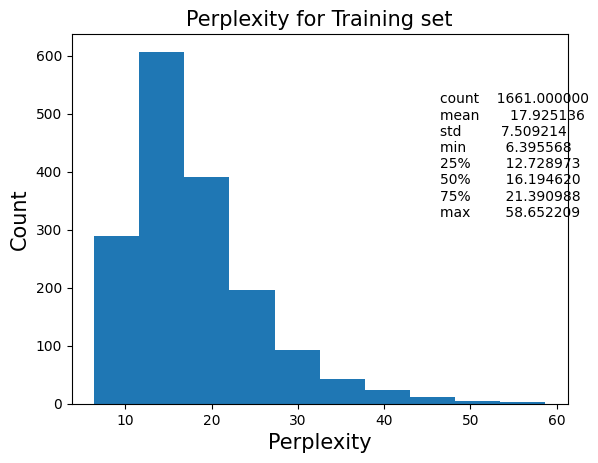

In [30]:
fig, ax = plt.subplots()
ax.hist(df_result_train['perplexity'])
plt.figtext(0.70,0.5, df_result_train['perplexity'].describe().to_string())

plt.xlabel("Perplexity",  fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Perplexity for Training set", fontsize=15)

Text(0.5, 1.0, 'Perplexity for Test set')

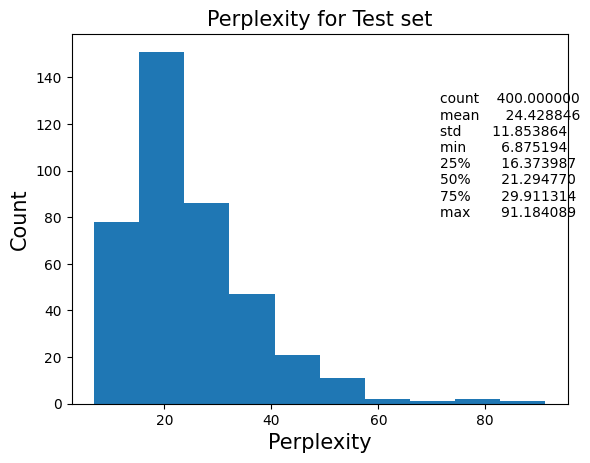

In [31]:
fig, ax = plt.subplots()
ax.hist(df_result_test['perplexity'])
plt.figtext(0.70,0.5, df_result_test['perplexity'].describe().to_string())

plt.xlabel("Perplexity",  fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Perplexity for Test set", fontsize=15)

Text(0.5, 1.0, 'Perplexity for Random data set')

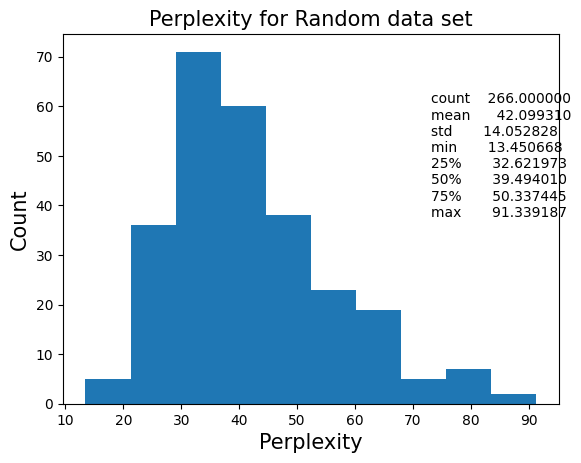

In [32]:
fig, ax = plt.subplots()
ax.hist(df_result_random1['perplexity'])
plt.figtext(0.70,0.5, df_result_random1['perplexity'].describe().to_string())

plt.xlabel("Perplexity",  fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Perplexity for Random data set", fontsize=15)

Text(0.5, 1.0, 'Perplexity for Indus Non Core region data set')

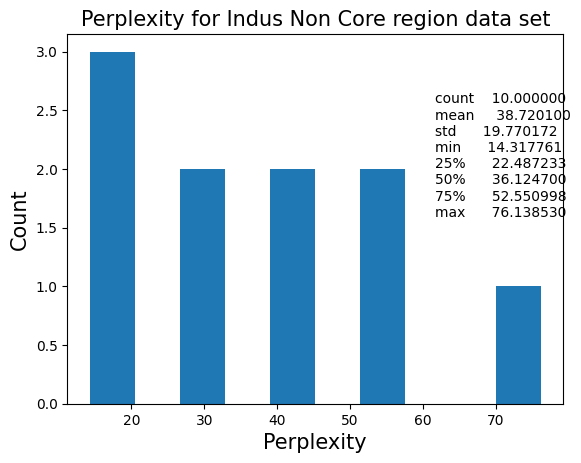

In [33]:
fig, ax = plt.subplots()
ax.hist(df_result_non_core['perplexity'])
plt.figtext(0.70,0.5, df_result_non_core['perplexity'].describe().to_string())

plt.xlabel("Perplexity",  fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Perplexity for Indus Non Core region data set", fontsize=15)